# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [59]:
# import libraries 
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
#  load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

### Memory Reduction

Due to the huge size of data, analysing the data is very time consuming. As such I started looking for solution online. I found a nice article "[How to handle BigData Files on Low Memory?](https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff#e618)"

In [212]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [ ]:
# Reduce Memory of all dataset
azdias_reduce = reduce_mem_usage(azdias)
customers_reduce = reduce_mem_usage(customers)
mailout_train_reduce = reduce_mem_usage(mailout_train)
mailout_test_reduce = reduce_mem_usage(mailout_test)

In [ ]:
# Save the reduced Memory file
azdias_reduce.to_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers_reduce.to_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')
mailout_train_reduce.to_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
mailout_test_reduce.to_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

### Loading memory reduced data

In [4]:
# Read data with after memory reduction
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Read information on the attributes 
# top-level list of attributes and descriptions, organized by informational category
attributes_des = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
# Detailed mapping of data values for each feature in alphabetical order
attributes_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [6]:
# View the data
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486465,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
customers. describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [10]:
attributes_info.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [11]:
def drop_unnamed_cols(df):
    """
    drop the Unnamed columns columns in the data

    """
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

In [12]:
# drop the unnamed columns
drop_unnamed_cols(azdias)
drop_unnamed_cols(customers)
drop_unnamed_cols(attributes_info)
drop_unnamed_cols(attributes_des)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [13]:
# Fill in the null values in the attribute column
attributes_info["Attribute"] = attributes_info["Attribute"].ffill()
attributes_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


## Data Preprocesing 

#### Address mixed type column

In [11]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [12]:
customers.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [13]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [14]:
attributes_info[attributes_info["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [ ]:
# Replace the X and XX with nan
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)

customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)

##### Look at the extra columnns in customers

In [ ]:
customers['PRODUCT_GROUP'].unique()

In [ ]:
customers['ONLINE_PURCHASE'].describe()

In [ ]:
customers['CUSTOMER_GROUP'].unique()

In [ ]:
# Drop the additional columns
customers.drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'],axis=1,inplace=True)

In [19]:
print(azdias.shape)
print(customers.shape)

(891221, 310)
(191652, 310)


### Looking at the missing values

In [15]:
# Attributes with missing or unknown
unknowns = []
for attribute in attributes_info['Attribute'].unique():
    _ = attributes_info.loc[attributes_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(attributes_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
print(unknowns)

                attribute                                 missing_or_unknown
0                AGER_TYP                                   [-1, 0, 1, 2, 3]
1    ALTERSKATEGORIE_GROB                            [-1,  0, 1, 2, 3, 4, 9]
2                ALTER_HH  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3               ANREDE_KZ                                     [-1,  0, 1, 2]
4     ANZ_HAUSHALTE_AKTIV                                                […]
..                    ...                                                ...
309        WOHNDAUER_2008                [-1,  0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
310              WOHNLAGE                       [-1, 0, 1, 2, 3, 4, 5, 7, 8]
311    WACHSTUMSGEBIET_NB                            [-1,  0, 1, 2, 3, 4, 5]
312        W_KEIT_KIND_HH                         [-1,  0, 1, 2, 3, 4, 5, 6]
313              ZABEOTYP                         [-1,  9, 1, 2, 3, 4, 5, 6]

[314 rows x 2 columns]


In [16]:
# creating a dataframe to get count/percentage of missing values in azdias and customers
azdias_nan=pd.DataFrame(azdias.isna().sum(axis=0)).reset_index()
azdias_nan.columns=['column','azdias_nan']
azdias_nan['azdiaz_nan_percent']=(azdias_nan['azdias_nan']/len(azdias))*100

customers_nan=pd.DataFrame(customers.isna().sum(axis=0)).reset_index()
customers_nan.columns=['column','customers_nan']
customers_nan['customer_nan_percent']=(customers_nan['customers_nan']/len(customers))*100
missing_values=pd.merge(azdias_nan, customers_nan, on='column')
missing_values=missing_values.sort_values(by=['azdias_nan','customers_nan'],ascending=[False,False])
missing_values

,column,azdias_nan,azdiaz_nan_percent,customers_nan,customer_nan_percent
7,ALTER_KIND4,890016,99.864792,191416,99.876860
6,ALTER_KIND3,885051,99.307691,190377,99.334732
5,ALTER_KIND2,861722,96.690047,186552,97.338927
4,ALTER_KIND1,810163,90.904837,179886,93.860748
100,EXTSEL992,654153,73.399639,85283,44.498883
...,...,...,...,...,...
346,SHOPPER_TYP,0,0.000000,0,0.000000
354,VERS_TYP,0,0.000000,0,0.000000
363,ZABEOTYP,0,0.000000,0,0.000000
364,ANREDE_KZ,0,0.000000,0,0.000000


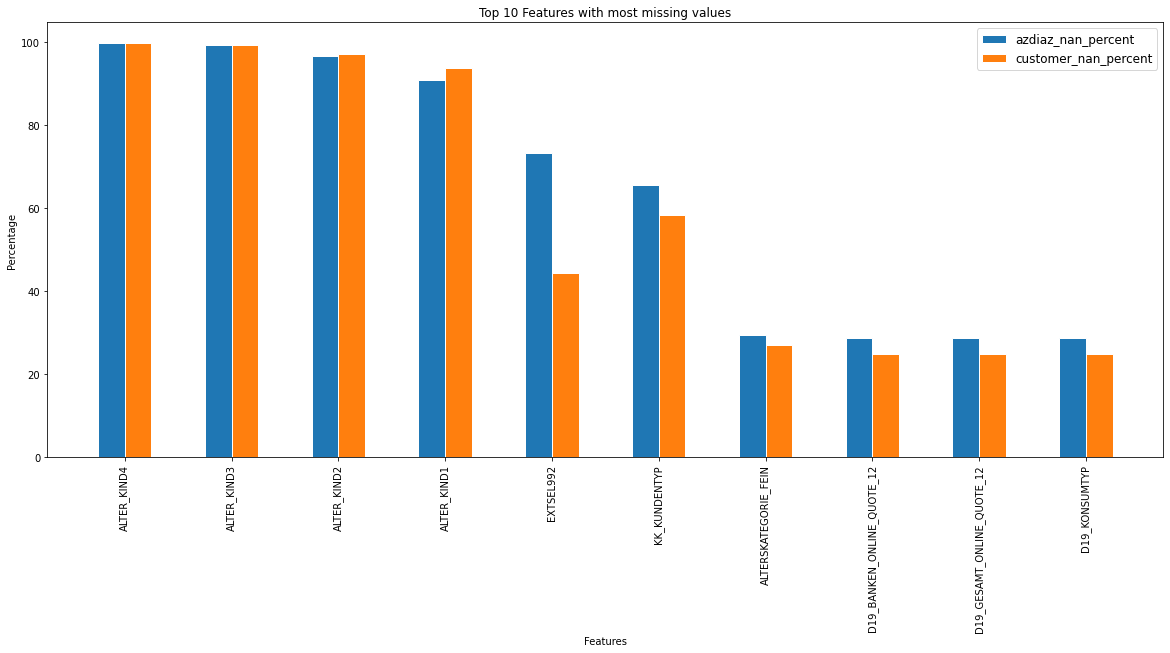

In [17]:
plt.figure(figsize=(20,8))
# set width of bar
barWidth = 0.25
# set height of bar
bars1 = missing_values['azdiaz_nan_percent'][:10]
bars2 = missing_values['customer_nan_percent'][:10]
label=missing_values['column'][:10]
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.bar(r2, bars2, width=barWidth, edgecolor='white')

 
# Add xticks on the middle of the group bars
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], label,rotation=90)
 
# Create legend & Show graphic
plt.title('Top 10 Features with most missing values')
plt.legend(['azdiaz_nan_percent','customer_nan_percent'],prop={'size': 12})
plt.show()

In [18]:
# we will drop the columns with highest missing value
# Only the first variable has more than 60% missing value
drop_cols=list(label[:4])
drop_cols

['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1']

#### Check categorical variables

In [19]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns",len(Numeric_columns))
print("Length of categorical columns",len(categorical_col))
print("Categorial columns are",categorical_col)

Length of Numeric columns 360
Length of categorical columns 6
Categorial columns are {'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}


In [20]:
# convert variables to numeric types
azdias[Numeric_columns] = azdias[Numeric_columns].apply(pd.to_numeric)
customers[Numeric_columns] = customers[Numeric_columns].apply(pd.to_numeric)

In [21]:
# Further analysis of categorical columns
category={}
def categorical_check():
    '''
    return a list of unique categorical variables 
    
    '''
    for i in categorical_col:
        category[i]=azdias[i].dropna().unique()
    return category
categorical_check()

{'D19_LETZTER_KAUF_BRANCHE': array(['D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
        'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
        'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
        'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
        'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
        'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
        'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
        'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
        'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
        'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
        'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object),
 'EINGEFUEGT_AM': array(['1992-02-10 00:00:00', '1992-02-12 00:00:00',
        '1997-04-21 00:00:00', ..., '2010-12-02 00:00:00',
        '2005-03-19 00:00:00', '2011-11-18 00:00:00'], dtype=object),
 'OST_WEST_KZ': array(['W', 

- 'EINGEFUEGT_AM' is time data
- 'CAMEO_INTL_2015', 'CAMEO_DEU_2015' and 'CAMEO_DEUG_2015' have XX and X as values

In [22]:
# After further analysis, these variables will be dropped
azdias=azdias.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
customers=customers.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)

azdias=azdias.drop('EINGEFUEGT_AM',axis=1)
customers=customers.drop('EINGEFUEGT_AM',axis=1)

#### Further analysis of missing values

In [24]:
# Let's have a closer look at 'Meaning' column in attribute values
attributes_info['Meaning'].value_counts()[:20]

unknown                            232
average                            162
low                                154
high                               154
very high                          142
very low                           139
none                               138
Multibuyer 0-12 months              34
no transaction known                34
Prospects > 24 months               34
Singlebuyer 13-24 months            34
Doublebuyer 0-12 months             34
Singlebuyer 0-12 months             34
Buyer > 24 months                   34
Multi-/Doublebuyer 13-24 months     34
no transactions known               22
highest affinity                    14
low affinity                        14
lowest affinity                     14
very high affinity                  14
Name: Meaning, dtype: int64

we have lots of unknown value in our dataset

In [25]:
# Investigate the unknown values
unknown_attributes_info = attributes_info[attributes_info["Meaning"] == "unknown"]
unknown_attributes_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


The unknown values are not consistent throughtout the dataset
- Some are represented as (-1,0) or (-1,9) or just -1. 
- We need to fix this and make the data consistent.

In [26]:
# Make data consistent
fix_unknown1=list(set(list(attributes_info[attributes_info['Value']=='-1, 0']['Attribute'])).intersection(set(azdias.columns)))
fix_unknown9=list(set(list(attributes_info[attributes_info['Value']=='-1, 9']['Attribute'])).intersection(set(azdias.columns)))

In [27]:
print(fix_unknown1)

['KKK', 'KBA05_GBZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'HH_EINKOMMEN_SCORE', 'ANREDE_KZ', 'REGIOTYP', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'ALTERSKATEGORIE_GROB']


In [28]:
print(fix_unknown9)

['KBA05_ALTER1', 'KBA05_HERST2', 'SEMIO_FAM', 'KBA05_KRSAQUOT', 'KBA05_MOD1', 'KBA05_HERST1', 'SEMIO_MAT', 'SEMIO_TRADV', 'KBA05_AUTOQUOT', 'KBA05_MAXHERST', 'KBA05_DIESEL', 'KBA05_KRSOBER', 'KBA05_ZUL3', 'SEMIO_KAEM', 'SEMIO_VERT', 'KBA05_CCM3', 'KBA05_ALTER4', 'SEMIO_REL', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_HERST4', 'KBA05_ZUL4', 'KBA05_MAXAH', 'KBA05_KRSHERST3', 'KBA05_KRSHERST1', 'SEMIO_PFLICHT', 'KBA05_KRSVAN', 'KBA05_MOTRAD', 'KBA05_HERST5', 'KBA05_ANHANG', 'KBA05_ZUL1', 'KBA05_CCM2', 'SEMIO_RAT', 'KBA05_VORB0', 'KBA05_ALTER2', 'KBA05_SEG4', 'KBA05_MAXBJ', 'KBA05_MOD8', 'KBA05_KRSKLEIN', 'KBA05_SEG9', 'SEMIO_ERL', 'SEMIO_KRIT', 'KBA05_SEG5', 'KBA05_KW2', 'KBA05_SEG7', 'KBA05_MAXSEG', 'KBA05_HERSTTEMP', 'KBA05_ALTER3', 'KBA05_KRSHERST2', 'KBA05_KW1', 'KBA05_SEG10', 'KBA05_MOD2', 'KBA05_SEG2', 'KBA05_SEG8', 'KBA05_VORB1', 'KBA05_MOTOR', 'KBA05_KRSZUL', 'SEMIO_SOZ', 'RELAT_AB', 'KBA05_MAXVORB', 'KBA05_FRAU', 'KBA05_MOD4', 'SEMIO_DOM', 'KBA05_HERST3', 'KBA05_MOD3', 'KBA05_SEG6', 'SEMI

In [29]:
azdias[fix_unknown1]=azdias[fix_unknown1].replace(0,-1)
azdias[fix_unknown9]=azdias[fix_unknown9].replace(9,-1)

In [30]:
customers[fix_unknown1]=customers[fix_unknown1].replace(0,-1)
customers[fix_unknown9]=customers[fix_unknown9].replace(9,-1)

#### Missing value in rows and columns

In [31]:
# Remove rows with most missing values
azdias=azdias[azdias.isnull().sum(axis=1)<=20]

customers=customers[customers.isnull().sum(axis=1)<=20]

In [33]:
# Dropping columns with most missing values
azdias=azdias.drop(drop_cols,axis=1)

customers=customers.drop(drop_cols,axis=1)

### Drop Correlated features above threshold of 75%


In [ ]:
# find correlation matrix and drop variables with greater than 75% correlation  
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .75)]

In [ ]:
azdias.drop(drop_columns,axis=1,inplace=True)

In [ ]:
customers.drop(drop_columns,axis=1,inplace=True)

### Imputing missing values
Find and relace nan values witht the mode

In [35]:
print(azdias.isna().sum().sum())
print(customers.isna().sum().sum())

2664489
131091


Text(0.5, 0, 'Percent of missing values')

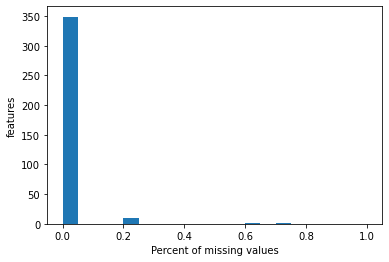

In [36]:
#looking for nans in columns
column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('features')
plt.xlabel('Percent of missing values')

In [37]:
azdias=azdias.fillna(azdias.mode().iloc[0])
customers=customers.fillna(customers.mode().iloc[0])

In [38]:
print(azdias.isna().sum().sum())
print(customers.isna().sum().sum())

0
0


In [39]:
print(azdias.shape)
print(customers.shape)

(745305, 360)
(132095, 363)


### One-hot encoding categorical variables

In [40]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in azdias",len(Numeric_columns))
print("Length of categorical columns in azdias",len(categorical_col))
print("Categorial columns in azdias are",categorical_col)

Length of Numeric columns in azdias 358
Length of categorical columns in azdias 2
Categorial columns in azdias are {'OST_WEST_KZ', 'CAMEO_DEU_2015'}


In [42]:
# Getting all numeric columns and categorical columns
Numeric_columns=customers.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(customers.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in customers",len(Numeric_columns))
print("Length of categorical columns in customers",len(categorical_col))
print("Categorial columns in customers are",categorical_col)

Length of Numeric columns in customers 359
Length of categorical columns in customers 4
Categorial columns in customers are {'PRODUCT_GROUP', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CUSTOMER_GROUP'}


In [43]:
azdias=pd.get_dummies(azdias)
customers=pd.get_dummies(customers)

In [44]:
print(azdias.shape)
print(customers.shape)

(745305, 405)
(132095, 411)


### Standardize the data

In [45]:
scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(azdias)
customers[customers.columns] = scaler.fit_transform(customers)

## Complete data preprocessing

In [ ]:
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')
def drop_unnamed_cols(df):
    """
    drop the Unnamed columns in the data

    """
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

fix_unknown1 = ['KKK', 'KBA05_GBZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'HH_EINKOMMEN_SCORE', 'ANREDE_KZ', 'REGIOTYP', 
                'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'ALTERSKATEGORIE_GROB']

fix_unknown9 =['KBA05_ALTER1', 'KBA05_HERST2', 'SEMIO_FAM', 'KBA05_KRSAQUOT', 'KBA05_MOD1', 'KBA05_HERST1', 'SEMIO_MAT', 
                'SEMIO_TRADV', 'KBA05_AUTOQUOT', 'KBA05_MAXHERST', 'KBA05_DIESEL', 'KBA05_KRSOBER', 'KBA05_ZUL3', 'SEMIO_KAEM',
               'SEMIO_VERT', 'KBA05_CCM3', 'KBA05_ALTER4', 'SEMIO_REL', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_HERST4', 
               'KBA05_ZUL4', 'KBA05_MAXAH', 'KBA05_KRSHERST3', 'KBA05_KRSHERST1', 'SEMIO_PFLICHT', 'KBA05_KRSVAN', 
               'KBA05_MOTRAD', 'KBA05_HERST5', 'KBA05_ANHANG', 'KBA05_ZUL1', 'KBA05_CCM2', 'SEMIO_RAT', 'KBA05_VORB0', 
               'KBA05_ALTER2', 'KBA05_SEG4', 'KBA05_MAXBJ', 'KBA05_MOD8', 'KBA05_KRSKLEIN', 'KBA05_SEG9', 'SEMIO_ERL', 
               'SEMIO_KRIT', 'KBA05_SEG5', 'KBA05_KW2', 'KBA05_SEG7', 'KBA05_MAXSEG', 'KBA05_HERSTTEMP', 'KBA05_ALTER3', 
               'KBA05_KRSHERST2', 'KBA05_KW1', 'KBA05_SEG10', 'KBA05_MOD2', 'KBA05_SEG2', 'KBA05_SEG8', 'KBA05_VORB1', 
               'KBA05_MOTOR', 'KBA05_KRSZUL', 'SEMIO_SOZ', 'RELAT_AB', 'KBA05_MAXVORB', 'KBA05_FRAU', 'KBA05_MOD4', 
               'SEMIO_DOM', 'KBA05_HERST3', 'KBA05_MOD3', 'KBA05_SEG6', 'SEMIO_LUST', 'KBA05_ZUL2', 'KBA05_CCM1', 
               'KBA05_MODTEMP', 'ZABEOTYP', 'KBA05_SEG1', 'SEMIO_KULT', 'KBA05_CCM4', 'KBA05_VORB2']

from sklearn.preprocessing import StandardScaler
def data_cleaning(df,name=None):
    '''
    Function take data as uinput and pre_processed the data 
    Output is cleaned data
    
    '''
#     drop_unnamed_cols(df)
    print("Shape before",df.shape)
    if name=='customers':
        df=df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)
    
    if name=='azdias':
        df=df[df.isnull().sum(axis=1)<=20].reset_index(drop=True)
        
    # finding numeric and categorical columns
    Numeric_columns=df.select_dtypes(include=np.number).columns.tolist()
    categorical_col=set(df.columns).difference(set(Numeric_columns))
    
    # numeric cols to numeric
    print(categorical_col)
    df[Numeric_columns]=df[Numeric_columns].apply(pd.to_numeric)
    
    # drop columns to avoid lot of columns
    df=df.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
    df=df.drop('EINGEFUEGT_AM',axis=1)
    df=df.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1'],axis=1)

    
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)
    #

    df[fix_unknown1]=df[fix_unknown1].replace(0,-1)
    df[fix_unknown9]=df[fix_unknown9].replace(9,-1)
    
    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .75)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)
    
    # fill nan with mode
    df=df.fillna(df.mode().iloc[0])
    print("Number of nan Values",df.isna().sum().sum())
    df=pd.get_dummies(df)
    
    # Standardised data
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df)
    print("shape after",df.shape)
    df = df.set_index('LNR')
    
    return df

# azdias_clean=data_cleaning(azdias,'azdias')
# customers_clean=data_cleaning(customers,'customers')

#### Fix columns difference

In [15]:
azdias_clean.shape

(744305, 323)

In [16]:
customers_clean.shape

(191652, 320)

In [18]:
# Difference in columns
print(set(list(customers_clean.columns)) - set(list(azdias_clean.columns)))

{'D19_KONSUMTYP', 'ANREDE_KZ', 'KBA13_BAUMAX', 'GEBAEUDETYP_RASTER', 'VK_DHT4A', 'CJT_TYP_3', 'WOHNDAUER_2008', 'KONSUMZELLE'}


In [19]:
# Difference in columns
print(set(list(azdias_clean.columns)) - set(list(customers_clean.columns)))

{'VERS_TYP', 'FINANZ_UNAUFFAELLIGER', 'NATIONALITAET_KZ', 'SEMIO_REL', 'KBA13_BJ_2000', 'KOMBIALTER', 'SEMIO_KRIT', 'SEMIO_KAEM', 'FINANZ_ANLEGER', 'CJT_TYP_4', 'KBA13_HHZ'}


In [20]:
# Drop columns
customers_clean.drop(columns=['GEBAEUDETYP_RASTER', 'D19_KONSUMTYP', 'KBA13_BAUMAX', 'KONSUMZELLE', 'CJT_TYP_3', 'ANREDE_KZ',
                              'WOHNDAUER_2008', 'VK_DHT4A'], inplace=True)

azdias_clean.drop(columns=['SEMIO_REL', 'FINANZ_ANLEGER', 'KBA13_HHZ', 'KOMBIALTER', 'KBA13_BJ_2000', 'CJT_TYP_4', 'SEMIO_KAEM',
                           'SEMIO_KRIT', 'FINANZ_UNAUFFAELLIGER', 'NATIONALITAET_KZ', 'VERS_TYP'], inplace=True)

In [21]:
print(azdias_clean.shape)
print(customers_clean.shape)


(744305, 312)
(191652, 312)


In [22]:
azdias_clean.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
count,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,...,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05,7.443050e+05
mean,8.343793e-15,-1.123348e-14,-2.371110e-15,4.843493e-16,5.360674e-15,1.091576e-14,4.510088e-15,-1.590556e-14,-2.702642e-15,-1.852886e-15,...,-5.352440e-15,1.058515e-14,2.018845e-14,1.703655e-15,-3.483268e-14,-3.938322e-15,2.873153e-15,9.391989e-15,2.676556e-14,-2.676556e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.731380e-01,-9.423887e-01,-1.419539e+00,-3.087966e+00,-5.435379e-01,-1.285939e-01,-2.970230e-01,-1.486979e+00,-6.049438e-02,-2.200629e+00,...,-2.118226e-01,-2.056151e-01,-1.533955e-01,-1.663754e-01,-1.933705e-01,-1.834139e-01,-1.964120e-01,-8.703665e-02,-5.198924e-01,-1.923475e+00
25%,-5.731380e-01,-9.423887e-01,-1.419539e+00,-4.315714e-01,-4.159390e-01,-1.285939e-01,-2.970230e-01,-6.270170e-01,-6.049438e-02,-1.898515e-01,...,-2.118226e-01,-2.056151e-01,-1.533955e-01,-1.663754e-01,-1.933705e-01,-1.834139e-01,-1.964120e-01,-8.703665e-02,-5.198924e-01,5.198924e-01
50%,-5.731380e-01,-3.943110e-01,2.840275e-01,2.325272e-01,-2.883401e-01,-1.285939e-01,-2.970230e-01,-6.270170e-01,-6.049438e-02,-1.898515e-01,...,-2.118226e-01,-2.056151e-01,-1.533955e-01,-1.663754e-01,-1.933705e-01,-1.834139e-01,-1.964120e-01,-8.703665e-02,-5.198924e-01,5.198924e-01
75%,1.047255e+00,1.249922e+00,8.082019e-01,4.538934e-01,9.445668e-02,-1.285939e-01,-2.970230e-01,2.329449e-01,-6.049438e-02,8.155374e-01,...,-2.118226e-01,-2.056151e-01,-1.533955e-01,-1.663754e-01,-1.933705e-01,-1.834139e-01,-1.964120e-01,-8.703665e-02,-5.198924e-01,5.198924e-01
max,2.667648e+00,1.249922e+00,1.332376e+00,2.446189e+00,3.365297e+01,6.263205e+01,2.235523e+01,3.721131e+01,5.873973e+01,5.842482e+00,...,4.720930e+00,4.863456e+00,6.519097e+00,6.010503e+00,5.171420e+00,5.452149e+00,5.091338e+00,1.148941e+01,1.923475e+00,5.198924e-01


In [24]:
customers_clean.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
count,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,...,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05
mean,-4.238650e-15,3.998211e-15,2.597975e-15,-1.138547e-15,-3.218478e-15,5.157062e-15,3.420783e-15,3.594420e-16,4.665904e-15,3.191686e-16,...,-1.793365e-15,-3.218736e-15,-3.250346e-15,-3.330061e-15,-1.176570e-15,3.265726e-15,5.354518e-17,-4.434903e-15,-2.903817e-15,2.901858e-15
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-9.660048e-01,-3.250739e-01,-1.174498e+00,-2.897572e+00,-3.164432e-01,-1.052176e-01,-2.383791e-01,-1.812549e+00,-1.162835e-01,-2.144783e+00,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,-3.986986e+00
25%,-9.660048e-01,-3.250739e-01,-1.174498e+00,-3.513469e-01,-2.359790e-01,-1.052176e-01,-2.383791e-01,-9.896773e-01,-1.162835e-01,-9.984408e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,2.508160e-01
50%,-2.474429e-01,-3.250739e-01,5.576999e-02,-6.843301e-02,-2.359790e-01,-1.052176e-01,-2.383791e-01,-1.668053e-01,-1.162835e-01,1.479014e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,2.508160e-01
75%,1.189681e+00,-3.250739e-01,8.759486e-01,4.973948e-01,-1.555148e-01,-1.052176e-01,-2.383791e-01,6.560666e-01,-1.162835e-01,1.479014e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,2.508160e-01
max,1.908243e+00,4.271391e+00,1.696127e+00,4.175275e+00,4.176631e+01,4.919838e+01,1.823360e+01,1.546776e+01,3.755438e+01,7.025955e+00,...,7.040441e+00,8.211133e+00,9.267017e+00,1.365075e+01,1.442217e+01,1.389879e+01,9.845381e+00,1.122899e+01,3.986986e+00,2.508160e-01


In [65]:
# Save cleaned data
azdias_clean.to_csv('azdias_cleaned.csv', index=False)
customers_clean.to_csv('customers_cleaned.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [25]:
# Load the data
azdias = pd.read_csv('azdias_cleaned.csv')

In [26]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-0.573138,1.249922,-1.419539,1.560724,0.158256,-0.128594,-0.297023,0.232945,-0.060494,-0.189851,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
1,-0.573138,1.249922,0.808202,0.675260,0.094457,-0.128594,-0.297023,-0.627017,-0.060494,-0.189851,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
2,1.857451,-0.942389,0.284028,-0.210205,-0.479738,-0.128594,-0.297023,-1.486979,-0.060494,-1.195240,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
3,-0.573138,-0.942389,1.201333,0.011161,-0.352140,-0.128594,-0.297023,1.952869,-0.060494,0.815537,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
4,2.667648,-0.942389,-0.109103,-0.874304,-0.224541,-0.128594,-0.297023,-0.627017,-0.060494,-1.195240,...,-0.211823,4.863456,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892


In [27]:
customers = pd.read_csv('customers_cleaned.csv')

In [28]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1.189681,-0.325074,0.192466,-0.068433,-0.235979,-0.105218,-0.238379,-0.166805,-0.116283,-2.144783,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
1,-0.966005,4.271391,0.329163,-0.068433,-0.235979,-0.105218,-0.238379,0.656067,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
2,-0.966005,-0.325074,-0.354319,-2.897572,-0.235979,-0.105218,-0.238379,-0.989677,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
3,0.471119,-0.325074,-0.080926,-0.634261,-0.316443,-0.105218,-0.238379,-1.812549,-0.116283,-2.144783,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
4,-0.966005,-0.325074,1.559431,1.063223,0.246806,-0.105218,-0.238379,1.478939,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816


In [29]:
print(azdias.shape)
print(customers.shape)

(744305, 312)
(191652, 312)


### Dimensionality Reduction - PCA

The data is now ready for dimensionality reduction. 
Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 

In [47]:
# Perform PCA 
pca = PCA()
azdias_pca = pca.fit_transform(azdias)

In [48]:
# Using this function from Udacity's class
def scree_plot(pca, num_components=None):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    if (num_components == None):
        num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[:num_components]
 
    plt.figure(figsize=(18, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

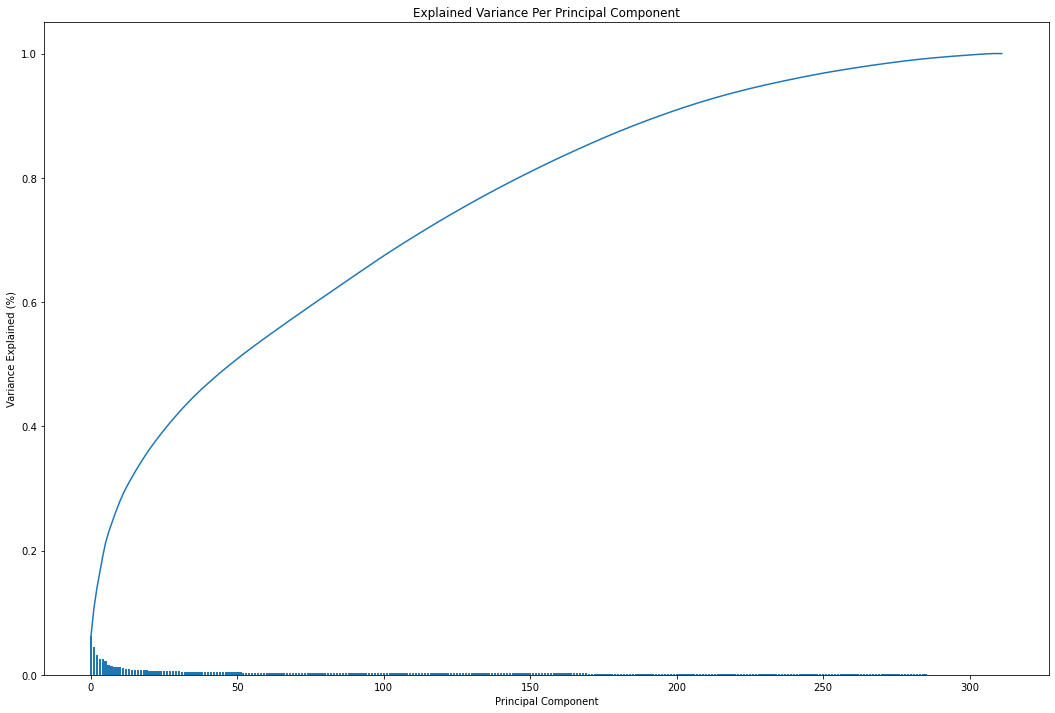

In [49]:
scree_plot(pca)

In [50]:
# Variance Explained by increasing components
for i in np.arange(10, len(pca.explained_variance_ratio_), 20):
    print('{} components explains {}% of variance'.format(i,(pca.explained_variance_ratio_[:i].sum()) * 100))

10 components explains 26.902190737478104% of variance
30 components explains 41.69724273591772% of variance
50 components explains 50.50828836219898% of variance
70 components explains 57.43200162028395% of variance
90 components explains 63.942451103513% of variance
110 components explains 70.1637418158014% of variance
130 components explains 75.7430885215517% of variance
150 components explains 80.72916389575636% of variance
170 components explains 85.17967055399541% of variance
190 components explains 89.07342290572663% of variance
210 components explains 92.3025479234256% of variance
230 components explains 94.80731100329045% of variance
250 components explains 96.75943904448626% of variance
270 components explains 98.25973590670007% of variance
290 components explains 99.35660537025502% of variance
310 components explains 100.0% of variance


In [53]:
# Choosing number of componetns
pca.explained_variance_ratio_[:180].sum()

0.8721086702452737

Choosing 180 components, the variance explained is around 87%

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=180)
azdias_pca = pca.fit_transform(azdias)

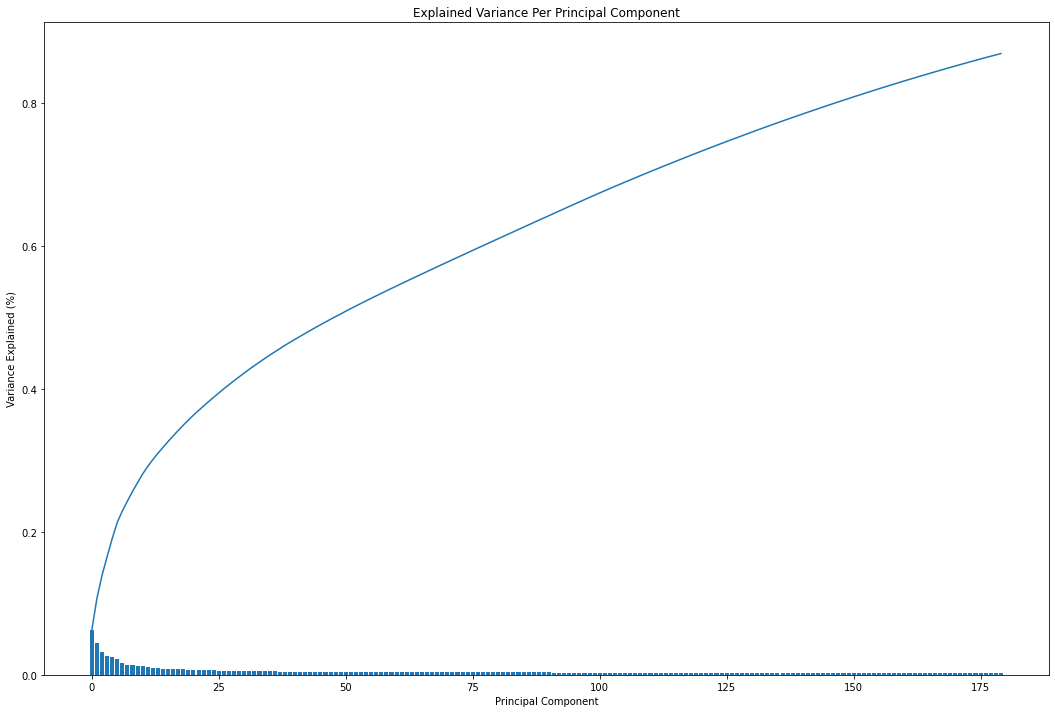

In [55]:
scree_plot(pca,num_components=180)

With 180 componets we were able to explained 87% of variability, we have reduced the number of features from 312 to only 180
- We have reduced the data by 132 features and still kept 87 % of variance explained.


In [57]:
# Visualize PCA Results
def pca_results(df, pca, component_no, features_no):
    '''
    Create a DataFrame of the PCA results
    Visualizes the PCA results for a speacific component number for a speacific number of features
    
    '''
    
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    # Capturing most interesting features which at the end and beginning of sorted list
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
                  figsize=(12, 6));
    plt.show()
    
    return pca_comp

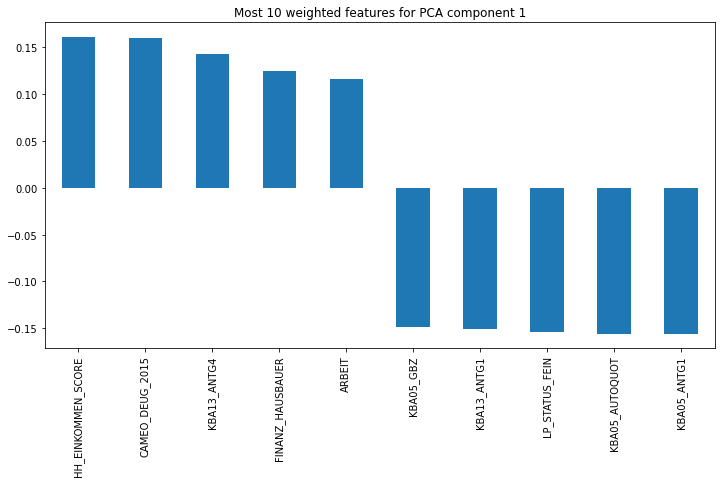

HH_EINKOMMEN_SCORE    0.1610
CAMEO_DEUG_2015       0.1595
KBA13_ANTG4           0.1430
FINANZ_HAUSBAUER      0.1244
ARBEIT                0.1163
KBA05_GBZ            -0.1489
KBA13_ANTG1          -0.1509
LP_STATUS_FEIN       -0.1539
KBA05_AUTOQUOT       -0.1557
KBA05_ANTG1          -0.1558
Name: 0, dtype: float64

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, 1, 5)

In [60]:

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Plot features_no features with the most positive and negative variance
# for a component_no PCA component
def pca_results(df, pca, component_no, features_no, show_plot=True):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    if show_plot:
        # Plot the result
        pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
                  figsize=(12, 6))
        plt.show()
    
    return pca_comp

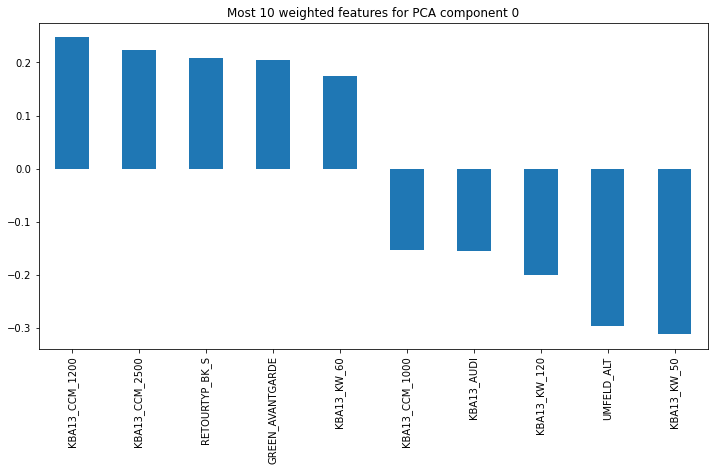

KBA13_CCM_1200      0.2470
KBA13_CCM_2500      0.2227
RETOURTYP_BK_S      0.2086
GREEN_AVANTGARDE    0.2043
KBA13_KW_60         0.1744
KBA13_CCM_1000     -0.1530
KBA13_AUDI         -0.1558
KBA13_KW_120       -0.1997
UMFELD_ALT         -0.2972
KBA13_KW_50        -0.3114
Name: 179, dtype: float64


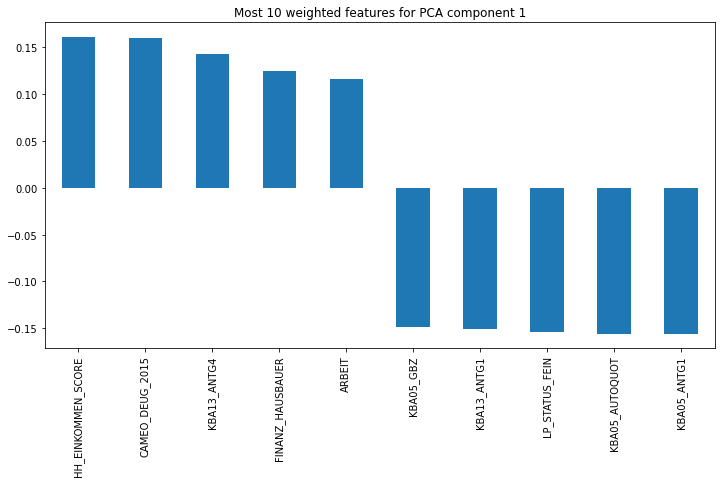

HH_EINKOMMEN_SCORE    0.1610
CAMEO_DEUG_2015       0.1595
KBA13_ANTG4           0.1430
FINANZ_HAUSBAUER      0.1244
ARBEIT                0.1163
KBA05_GBZ            -0.1489
KBA13_ANTG1          -0.1509
LP_STATUS_FEIN       -0.1539
KBA05_AUTOQUOT       -0.1557
KBA05_ANTG1          -0.1558
Name: 0, dtype: float64


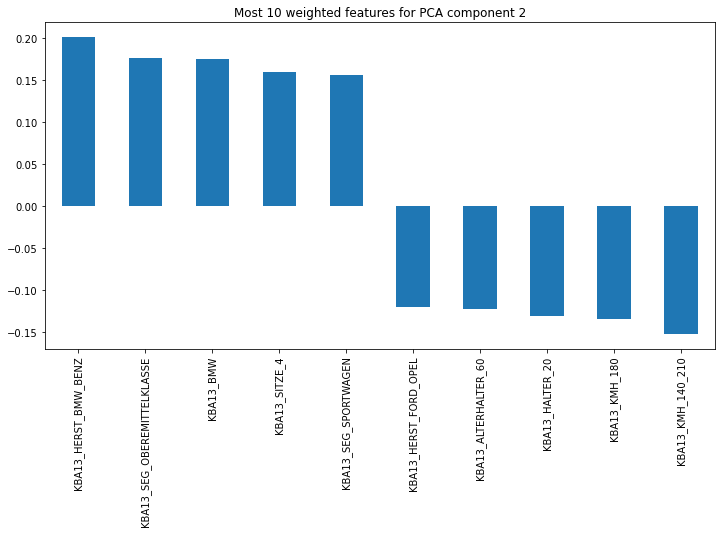

KBA13_HERST_BMW_BENZ           0.2009
KBA13_SEG_OBEREMITTELKLASSE    0.1758
KBA13_BMW                      0.1745
KBA13_SITZE_4                  0.1592
KBA13_SEG_SPORTWAGEN           0.1559
KBA13_HERST_FORD_OPEL         -0.1196
KBA13_ALTERHALTER_60          -0.1224
KBA13_HALTER_20               -0.1312
KBA13_KMH_180                 -0.1340
KBA13_KMH_140_210             -0.1519
Name: 1, dtype: float64


In [61]:

# Check first 3 components
for i in np.arange(0, 3, 1):
    res = pca_results(azdias, pca, i, 5)
    print(res)

#### Interprete PCA Results

The top 10 weighted features for the PCA for the first 3 components.

##### COMPONENT 0

***Positively correlated features***
- **_KBA13_CCM_1200_** -  share of cars with 1000ccm to 1199ccm within the PLZ8
- **_KBA13_CCM_2500_** - share of cars with 2000ccm to 2499ccm within the PLZ8
- **_RETOURTYP_BK_S_** - return type- how likely a shopper is going to return to shop again 
- **_GREEN_AVANTGARDE_** - the environmental sustainability is the dominating movement in the youth of these consumers
- **_KBA13_KW_60_** - share of cars with an engine power between 51 and 60 KW - PLZ8

***Negatively correlated features***
- **_KBA13_CCM_1000_** - share of cars with less than 1000ccm within the PLZ8
- **_KBA13_AUDI_** - share of AUDI within the PLZ8
- **_KBA13_KW_120_** - share of cars with an engine power between 111 and 120 KW - PLZ8
- **_UMFELD_ALT_** -
- **_KBA13_KW_50_** - share of cars with an engine power between 41 and 50 KW - PLZ8


##### COMPONENT 1

***Positively correlated features***
- **_HH_EINKOMMEN_SCORE_** - estimated household net income
- **_CAMEO_DEUG_2015_** - Typology clasification based on classes (upper/lower class)
- **_KBA13_ANTG4_** - unknown attributes with associated with car in PLZ8
- **_FINANZ_HAUSBAUER_** - financial typology: main focus is the own house
- **_ARBEIT_** - share of unemployed person in the community	

***Negatively correlated features***
- **_KBA05_GBZ_** - number of buildings in the microcell	
- **_KBA13_ANTG1_** - share of unknown car in PLZ8
- **_LP_STATUS_FEIN_** - social status 
- **_KBA05_AUTOQUOT_** - share of cars per household	
- **_KBA05_ANTG1_50_** - number of 1-2 family houses in the cell	

##### COMPONENT 2

***Positively correlated features***
- **_KBA13_HERST_BMW_BENZ_** - share of BMW & Mercedes Benz within the PLZ8
- **_KBA13_SEG_OBEREMITTELKLASSE_** - share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
- **_KBA13_BMW_** - share of BMW within the PLZ8	
- **_KBA13_SITZE_4_** - number of cars with less than 5 seats in the PLZ8
- **_KBA13_SEG_SPORTWAGEN_** - share of sportscars within the PLZ8	

***Negatively correlated features***
- **_KBA13_HERST_FORD_OPEL_** - share of Ford & Opel/Vauxhall within the PLZ8		
- **_KBA13_ALTERHALTER_60_** - share of car owners between 46 and 60 within the PLZ8
- **_KBA13_HALTER_20_** - share of car owners below 21 within the PLZ8
- **_KBA13_KMH_180_** - share of cars with max speed between 110 km/h and 180km/h within the PLZ8	
- **_KBA13_KMH_140_210_** - share of cars with max speed between 140 and 210 km/h within the PLZ8

###  Clustering

Apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

#### K-Means - General population (azdias)

In [184]:
# K-Means fucntion from Udacity k-means
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, max_iter=30) 

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [185]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centers = np.arange(1,30,2)

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

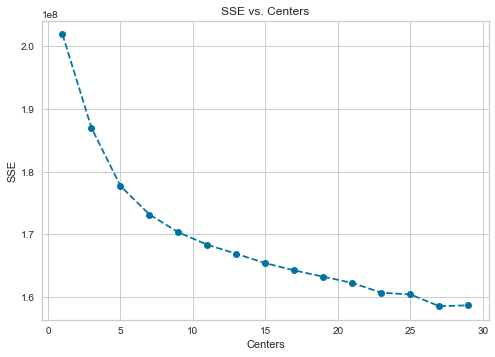

In [186]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Centers');
plt.ylabel('SSE');
plt.title('SSE vs. Centers');

To find the right number of clusters, Elbow Method were used. Unfortunatelly there is no clearly distinguishable elbow in the plot, nevertheless the plot starts to flatten more after K = 22 so 22 is chosen as the number of clusters for the full dataset.

In [187]:
# Create a toy dataset to reduce computation time
# Reduce the size to 25%
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.25), replace=False)]
azdias_pca_sample

array([[-3.20821035, -3.60203422, -5.14383919, ...,  0.72651149,
        -0.73178889, -0.75640715],
       [-3.05669414, -0.97492101,  1.38158378, ..., -0.14130874,
         0.21353974, -0.85775866],
       [-3.01630546, -5.1754569 ,  2.57128741, ..., -0.83877368,
         0.35747054,  0.2872013 ],
       ...,
       [-3.94199963,  2.36402336, -0.79743758, ..., -0.69291247,
        -0.87816196, -1.02325298],
       [ 5.45383941,  2.35557783,  2.25302965, ..., -1.23103393,
         0.46970119, -0.98848325],
       [-6.14226593,  0.73065701, -6.88825624, ...,  2.29241563,
        -0.11851782, -0.63637582]])

In [188]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

sse = [] # Sum of Squared Errors
k_range = np.arange(10, 31)

for k in k_range:
    kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca_sample)
    score = np.abs(kmeans.score(azdias_pca_sample))
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 10 k, with SSE 42337008.71951024


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 11 k, with SSE 42108385.569391504


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 12 k, with SSE 41906210.49174486


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 13 k, with SSE 41654754.68684188


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 14 k, with SSE 41508817.79501742


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 15 k, with SSE 41285869.88956661


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 16 k, with SSE 41241457.3415008


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 17 k, with SSE 40966761.46979014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 18 k, with SSE 40845352.977612875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 19 k, with SSE 40718156.47682739


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 20 k, with SSE 40577453.279080756


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 21 k, with SSE 40513453.43081363


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 22 k, with SSE 40394317.27126055


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 23 k, with SSE 40303808.14636363


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 24 k, with SSE 40113295.162932016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 25 k, with SSE 40007746.871411614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 26 k, with SSE 39924864.91257075


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 27 k, with SSE 39764339.511834346


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 28 k, with SSE 39704357.21721037


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 29 k, with SSE 39630365.446084544


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Clustering done for 30 k, with SSE 39517074.27236323


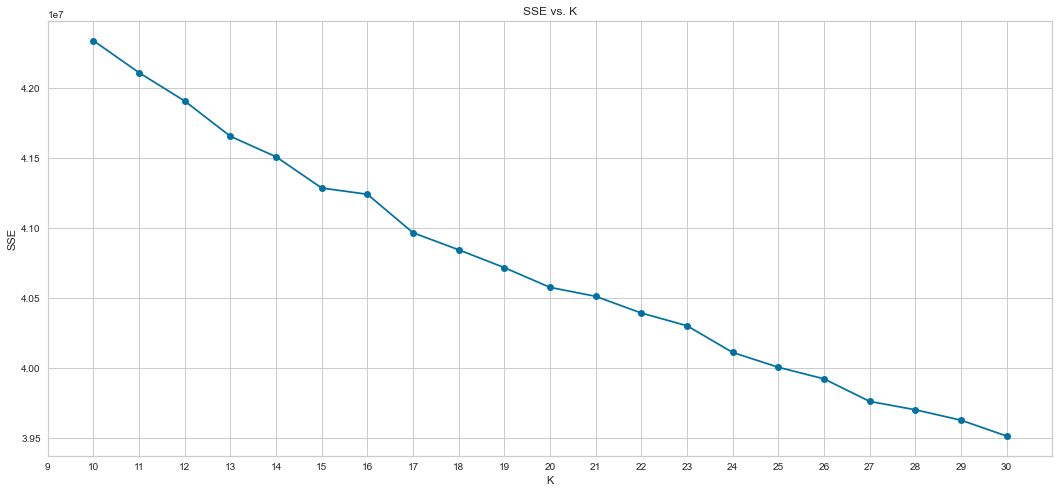

In [189]:
# Investigate the change in within-cluster distance across number of clusters.
# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(k_range, sse, linestyle='-', marker='o');

By using elbow method we can see a strong leveling off at 24 clusters, which suggests 24 clusters should be used

In [190]:
# Re-fit the k-means model with the selected number of clusters and obtain
k = 24
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


### Apply all the process to the customers dataset

In [191]:
# Load the cleaned customer dataset
customers = pd.read_csv('customers_cleaned.csv')

In [192]:
# Applying PCA
customers_pca = pca.transform(customers)

In [193]:
### Step 3: Clustering
# Cluster predictions for the general population demographics data.
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(customers_pca)
customer_clusters = kmeans.predict(customers_pca)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


### Compare Customer Data to Demographics Data¶


In [194]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_clusters = pd.Series(population_clusters)
popc = population_clusters.value_counts().sort_index()
popc = pd.Series(popc)

customer_clusters = pd.Series(customer_clusters)
custc = customer_clusters.value_counts().sort_index()
custc = pd.Series(custc)


In [195]:
# Create a dataset summarizing clustering information
pop_cust = pd.concat([popc, custc], axis=1).reset_index()
pop_cust.columns = ['cluster', 'population', 'customers']

# Recalculate index
pop_cust.index = pop_cust.index + 1
# Sort by cluster (index)
pop_cust.sort_index(inplace=True)

# Calculate proprotions
pop_cust['customer_prop'] = pop_cust['customers'] / pop_cust['customers'].sum()
pop_cust['population_prop'] = pop_cust['population'] / pop_cust['population'].sum()
pop_cust

,cluster,population,customers,customer_prop,population_prop
1,0,35366,198,0.001033,0.047515
2,1,38586,10863,0.056681,0.051842
3,2,59705,47488,0.247782,0.080216
4,3,56778,932,0.004863,0.076283
5,4,13764,126,0.000657,0.018492
6,5,12607,12885,0.067231,0.016938
7,6,25978,2981,0.015554,0.034902
8,7,36688,1143,0.005964,0.049292
9,8,69189,9408,0.049089,0.092958
10,9,15710,14066,0.073393,0.021107


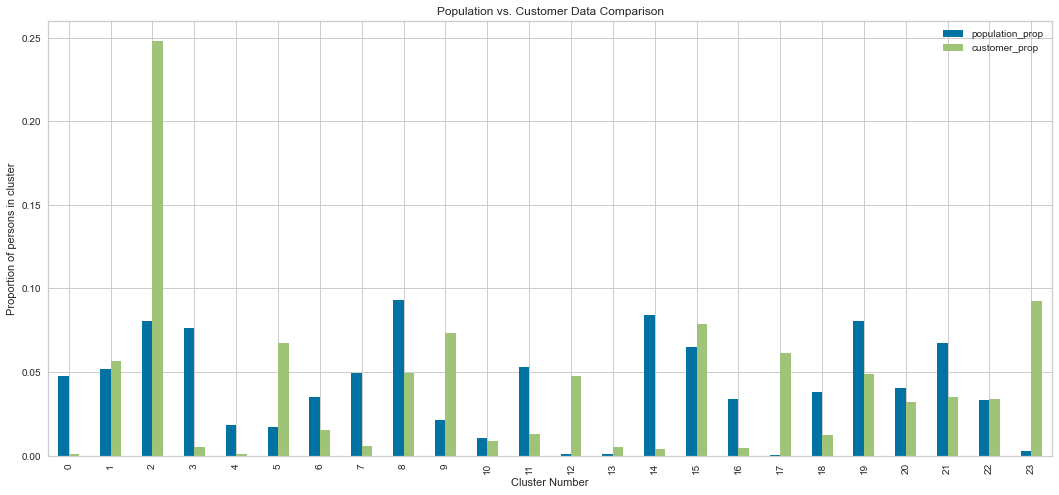

In [196]:
# Compare visually
pop_cust.plot(x='cluster', y=['population_prop', 'customer_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data Comparison')
plt.xlabel('Cluster Number')
plt.ylabel('Proportion of persons in cluster')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [120]:
# Load the libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

In [140]:
# Load Memory reduced train data
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [141]:
# Choose the response 
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']
df_mailout_train  = data_cleaning(X)

Shape before (42962, 366)
{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}
shape after corr (42962, 276)
Number of nan Values 0
shape after (42962, 321)


In [142]:
X_train,X_test,y_train,y_test = train_test_split(df_mailout_train,y,random_state=42,test_size=0.3)

In [143]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=42,test_size=0.3)

##### XGB Model

In [144]:
model_xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=0.7, eval_metric='auc', gamma=1.0,
                        learning_rate=0.01, max_delta_step=0, max_depth=7,
                        min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
                        nthread=None, objective='binary:logistic', random_state=42,
                        reg_alpha=1e-07, reg_lambda=1, scale_pos_weight=1, seed=None,
                        silent=1, subsample=0.5)

In [145]:
#Fit model
model_xg.fit(X_train,y_train)

[21:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
             gamma=1.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None,
             monotone_constraints='()', n_estimators=250, n_jobs=-1, nthread=4,
             num_parallel_tree=1, objective='binary:logistic', random_state=42,
             reg_alpha=1e-07, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, ...)

In [146]:
# Evaluate Model
from sklearn.metrics import roc_auc_score
pred_train = model_xg.predict(X_train)
pred_test = model_xg.predict(X_test)
pred_val = model_xg.predict(X_val)

In [147]:
# Train
roc_auc_score(y_train,pred_train)

0.9084999443701693

In [148]:
# Test
roc_auc_score(y_test,pred_test)

0.7758407076409347

In [149]:
# Validation
roc_auc_score(y_val,pred_val)

0.7770589970636395

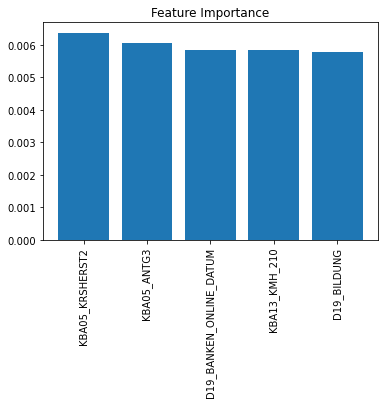

In [150]:
# Calculate feature importances
importances = model_xg.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:5]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices][:5]


# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(5), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(5) ,names, rotation=90)

# Show plot
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [134]:
# Load Test data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [135]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [136]:
mailout_test = mailout_test.drop(['Unnamed: 0'], axis=1)

In [137]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [138]:
# Apply the preprocessing step
mailout_test_clean = data_cleaning(mailout_test)

Shape before (42833, 366)
{'OST_WEST_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'EINGEFUEGT_AM'}
shape after corr (42833, 276)
Number of nan Values 0
shape after (42833, 321)


In [156]:
# Make prediction
testpred = model_xg.predict(mailout_test_clean)

In [159]:
# prediction_for_kaggle = reg_model.predict(mailout_test_clean)
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=testpred)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)


In [160]:
# Kaggle submission csv file
df_kaggle.to_csv('submission1.csv')

For first try I got a score of 0.79473 but I will try to make some improvement

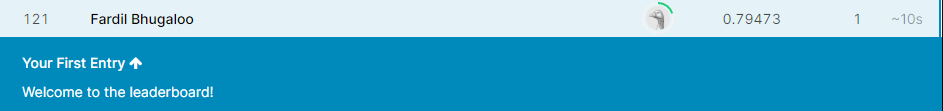

## Improvement

In [172]:
# import packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
SEED=42

In [128]:
# Load train data
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [129]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [130]:
mailout_train = mailout_train.drop(['Unnamed: 0'], axis=1)

In [131]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [132]:
# Define the response variable
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [133]:
# Data Pre_processing 
df_mailout_train  = data_cleaning(X)

Shape before (42962, 366)
{'OST_WEST_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'EINGEFUEGT_AM'}
shape after corr (42962, 276)
Number of nan Values 0
shape after (42962, 321)


In [143]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(df_mailout_train,y,stratify=y,random_state=SEED,test_size=0.2)

#### Compare models

In [154]:
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=SEED)

In [155]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

In [156]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [157]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [158]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.689629,1.935
1,DecisionTreeClassifier,0.540728,2.31003
2,RandomForestClassifier,0.578212,13.6376
3,GradientBoostingClassifier,0.76548,53.774
4,AdaBoostClassifier,0.734101,14.3908
5,XGBClassifier,0.695248,16.8857


#### Grid Search 

##### AdaBoostClassifier

In [160]:
#Define the paramaters for GridSearch
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }


adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [225]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Best Score:  0.7597514028459369
Best Params:  {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 1000}
Wall time: 1h 46min 59s


In [226]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7613


In [227]:

def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

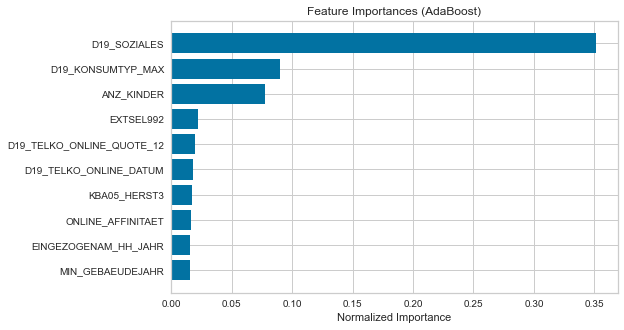

In [228]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=df_mailout_train.columns)

##### XGBClassifier

In [167]:
xgb_param_grid = {"max_depth": [5,10,20,30],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "gamma":[0.1,0.5,1.0],
              "n_estimators":[50,100,150,200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=-1, eval_metric="auc",
                                                            silent=1,random_state=SEED), 
                           param_grid = xgb_param_grid, 
                           scoring = "roc_auc",
                           cv = 5, n_jobs = -1, verbose=2)

In [168]:
%%time
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 168.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 294.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 452.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 551.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 9h 11min 34s


In [169]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7633140979328148
Best Params:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [170]:
preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

ROC score on validation data: 0.7703


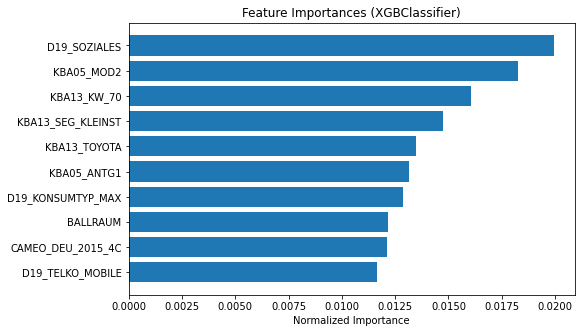

In [171]:
plot_feature_importances(model=best_xgb, model_name="XGBClassifier", feature_names=df_mailout_train.columns)


### Kaggle Submisson

#### AdaBoost

In [229]:
# fit model
best_adaboost.fit(df_mailout_train, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, min_samples_split=3,
                           n_estimators=1000)

In [230]:
# Make prediction on test data
preds_test_adaboost = best_adaboost.predict_proba(mailout_test_clean)[:,1]


In [231]:
# convert to dataFrame with appropriate columns
kaggle_adaboost = pd.DataFrame(index=mailout_test["LNR"], data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [232]:
# save model to csv for submission
kaggle_adaboost.to_csv('submission5.csv')

#### XGBoost

In [179]:
# fit XGBoost model
best_xgb.fit(df_mailout_train, y)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [180]:
# Make prediction
preds_test_xgb = best_xgb.predict_proba(mailout_test_clean)[:,1]

In [181]:
## convert to dataFrame with appropriate columns
kaggle_xgb = pd.DataFrame(index=mailout_test["LNR"], data=preds_test_xgb)
kaggle_xgb.rename(columns={0: "RESPONSE"}, inplace=True)

In [182]:
# save model to csv for submission
kaggle_xgb.to_csv("submission3.csv")

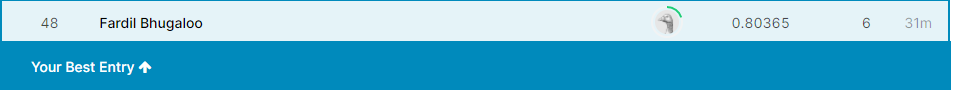

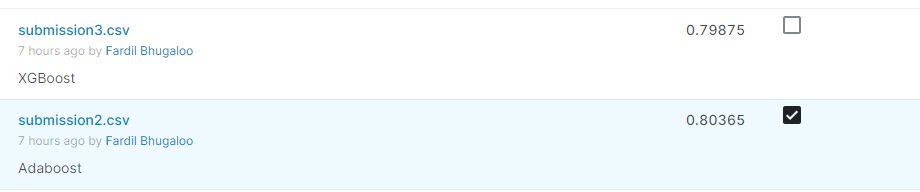

The Adaboost model with hyperparameter tuning performns better and is also take less time